In [20]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mping

## generate vectors to hold the cross points

img_points = [] # real points in the figure
obj_points = []

objp = np.zeros((6*9,3), np.float32) # desired points
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [21]:
## read in all the images using glob API and find chessboard corners
import glob

images = glob.glob('.\camera_cal\calibration*.jpg')

for file in images:
    # read the image
    image = mping.imread(file)
    
    # gray scale the image   
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if found, add the object and image points 
    if ret:
        img_points.append(corners)
        obj_points.append(objp)
        
## define a fuction to calibrate and undistort the pictures from this camera

def cal_undistort(image, img_points, obj_points):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    
    return cv2.undistort(image, mtx, dist, None, mtx)

## transform the pictures and save it

def wrap(img):
    src = np.float32([[190,720], [586,455], [696,455], [1130,720]])
    dst = np.float32([[240,720], [240,0], [1040,0], [1040, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    wraped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return wraped

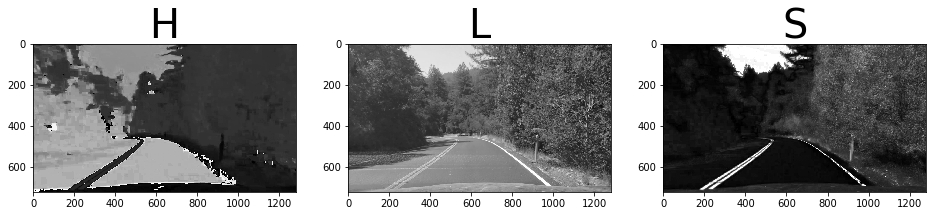

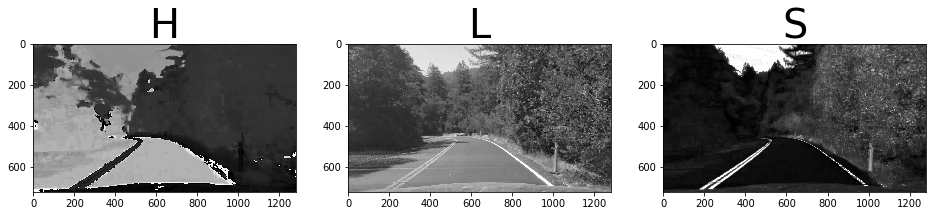

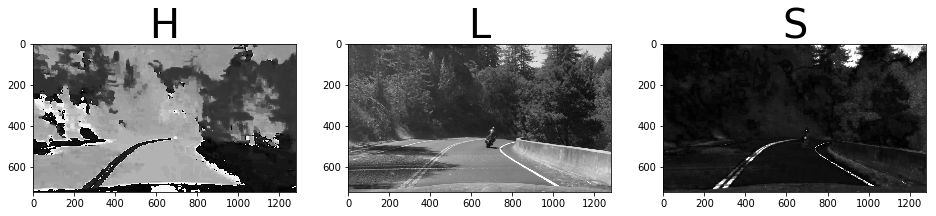

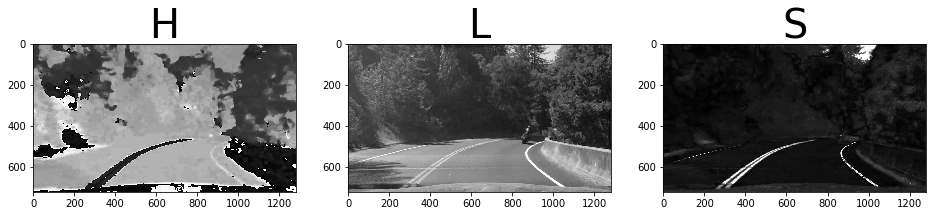

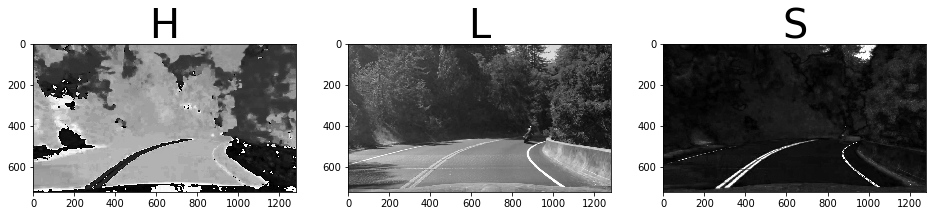

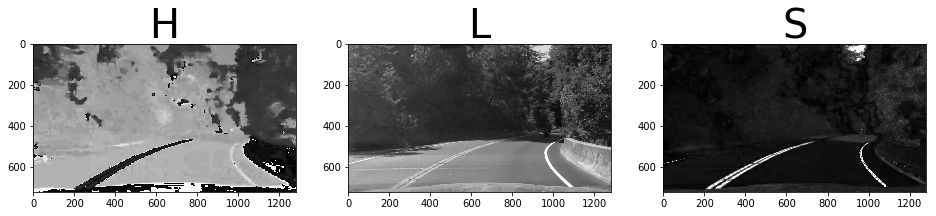

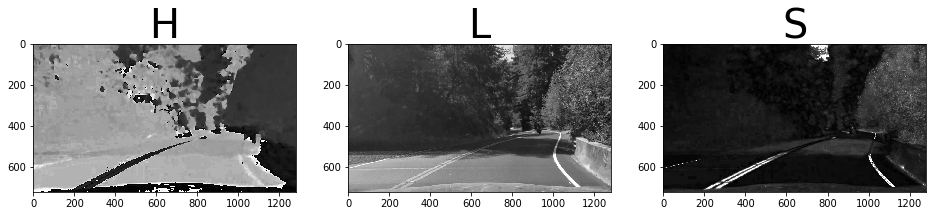

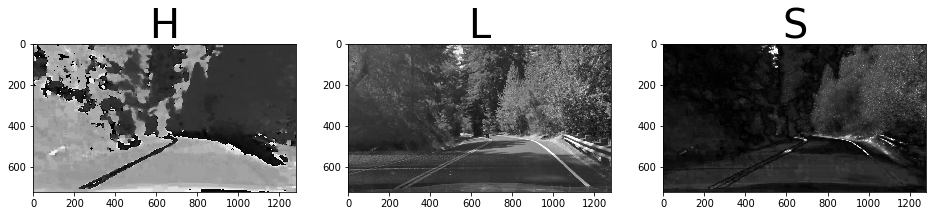

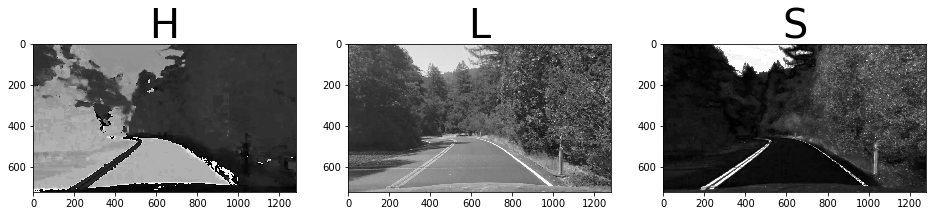

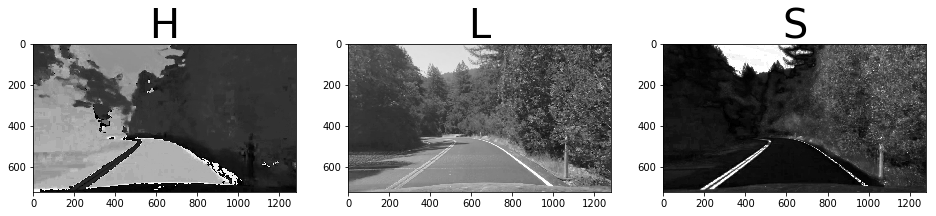

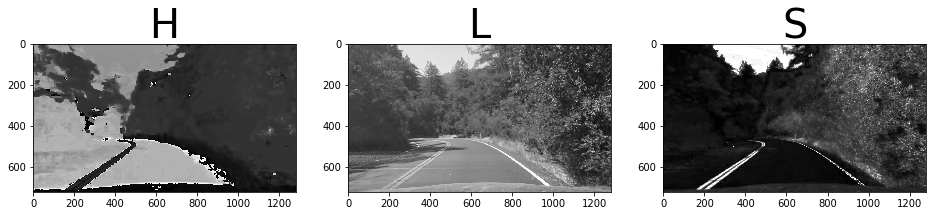

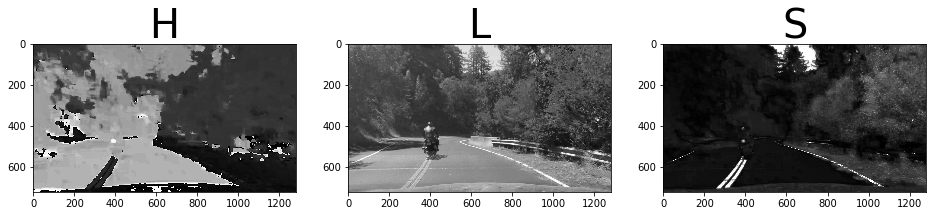

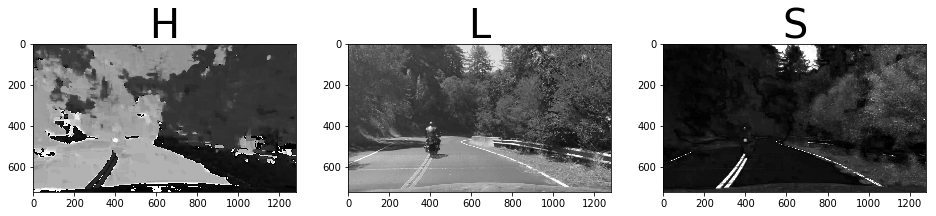

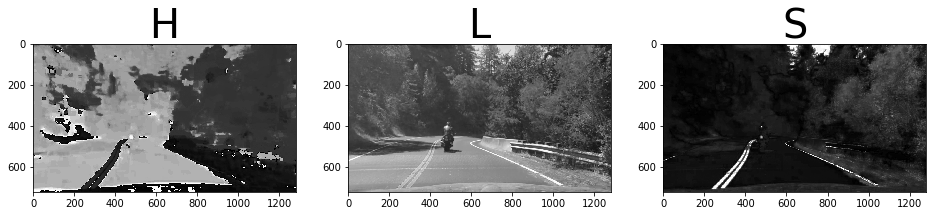

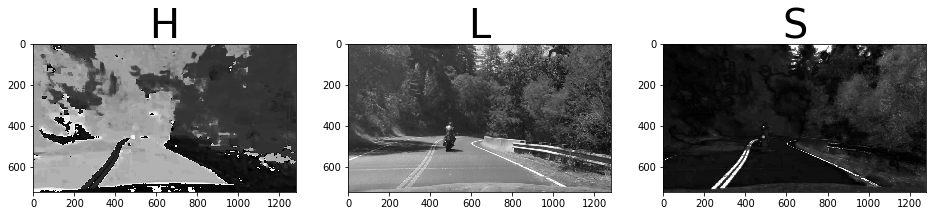

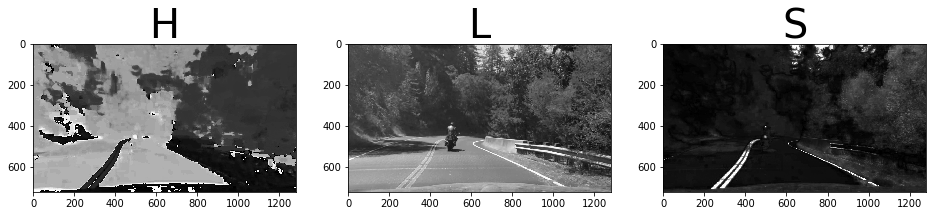

In [22]:
# read and translate the figure

images = glob.glob('./output_images/harder_challenge/test*.jpg')

for file in images:
    image = mping.imread(file)
    figurename = file.split("\\")[-1]
    image = cal_undistort(image, img_points, obj_points)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # show every channel in grayscale

    H = image[:,:,0]
    L = image[:,:,1]
    S = image[:,:,2]
    plt.figure(figsize=(16,6))
    plt.subplot(1,3,1)
    plt.imshow(H, cmap='gray')
    plt.subplot(1,3,1).set_title('H', fontsize=40)
    plt.subplot(1,3,2)
    plt.imshow(L, cmap='gray')
    plt.subplot(1,3,2).set_title('L', fontsize=40)
    plt.subplot(1,3,3)
    plt.imshow(S, cmap='gray')
    plt.subplot(1,3,3).set_title('S', fontsize=40)

In [3]:
## define the function to implement sobel threshold in S and L channels

S_thres = (200,255)
H_thres = (22,24)
L_thres = (170,255)

def hls_pip(img, thres_s=(0,255), thres_h = (0,255), thres_l=(0,255)):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = image[:,:,0]
    S = image[:,:,2]
    L = image[:,:,1]
    
    binary_output = np.zeros_like(S)
    binary_output[((S<thres_s[1]) & (S>thres_s[0]))|((H<thres_h[1]) & (H>thres_h[0]))|((L<thres_l[1]) & (L>thres_l[0]))] = 1
    
    return binary_output

In [ ]:
# test the function
for file in images:
    image = mping.imread(file)
    figurename = file.split("\\")[-1]
    image = cal_undistort(image, img_points, obj_points)
    img_binary = hls_pip(image, thres_s=S_thres, thres_h=H_thres, thres_l=L_thres)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(img_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

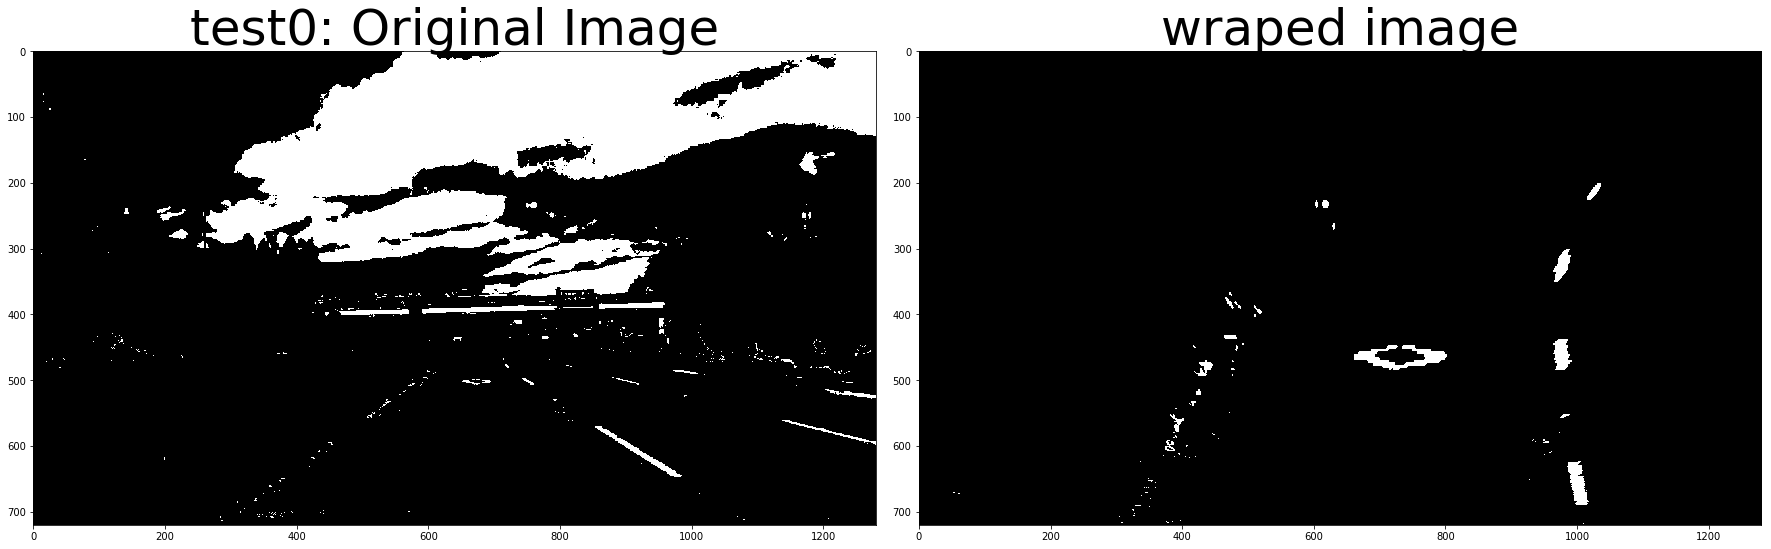

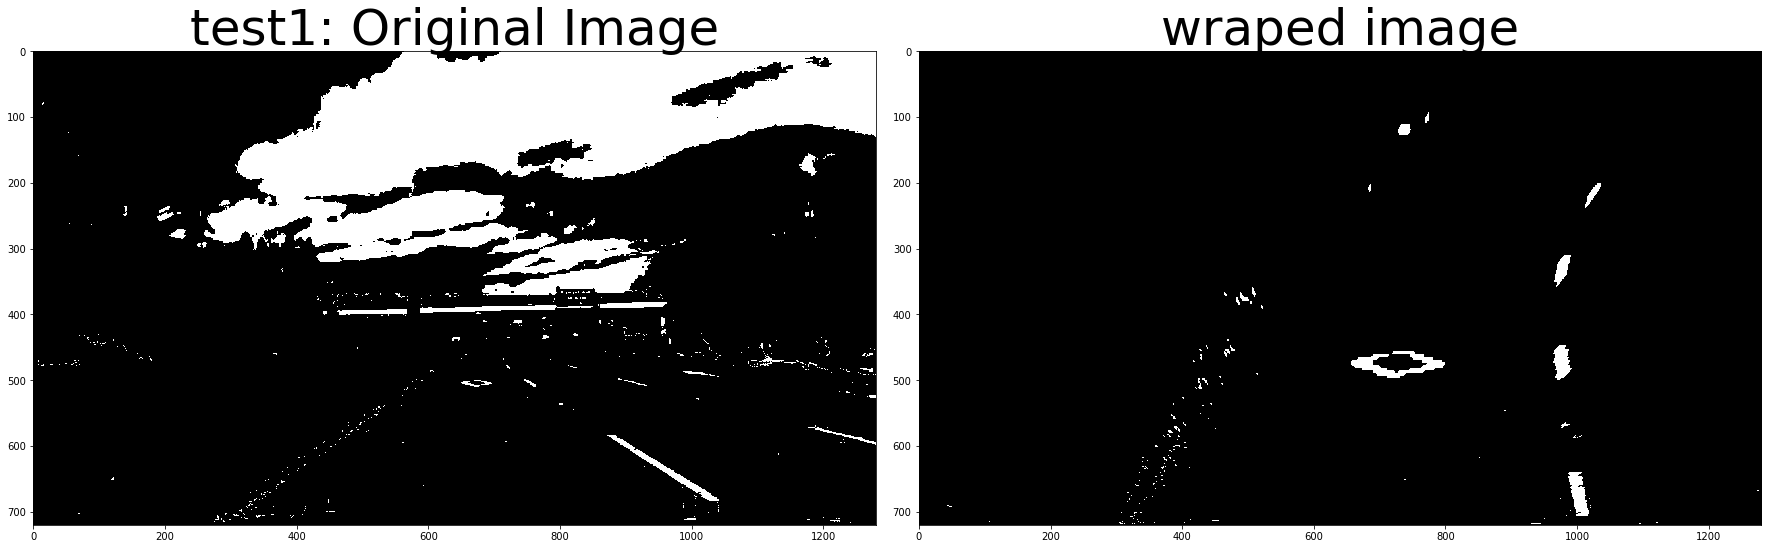

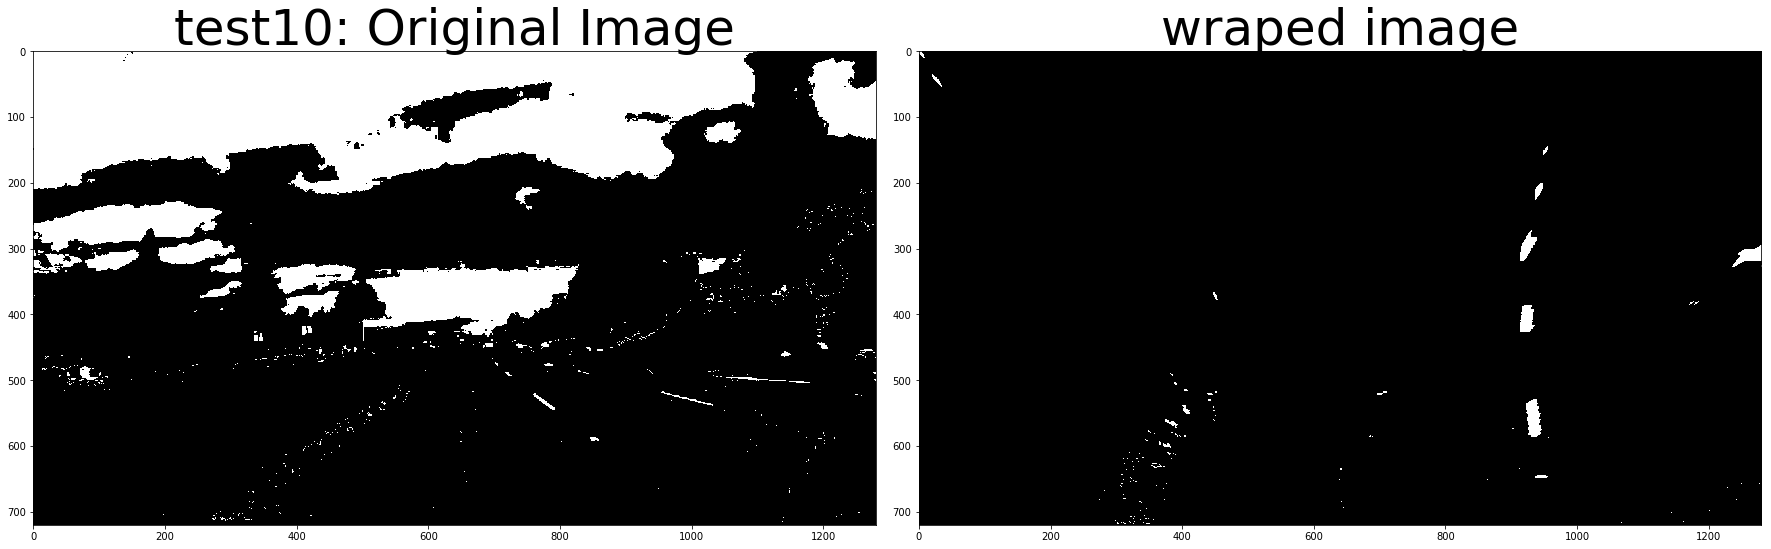

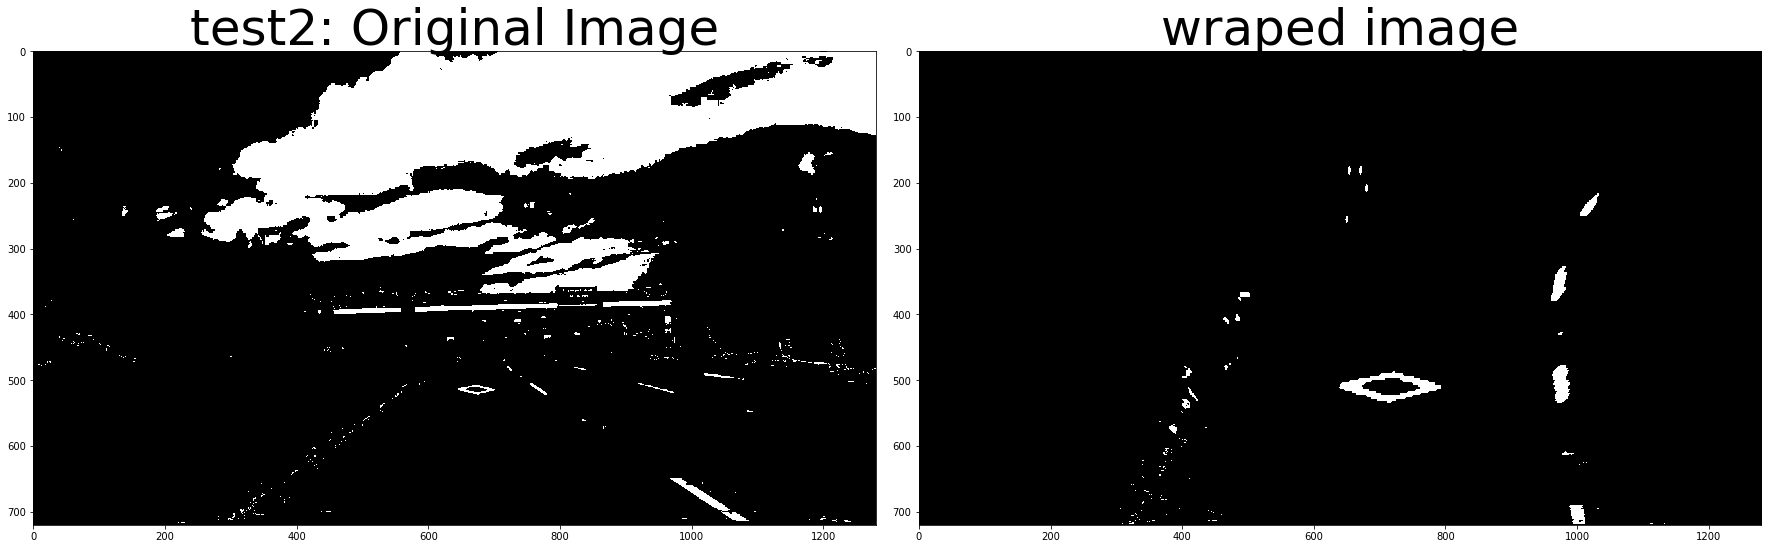

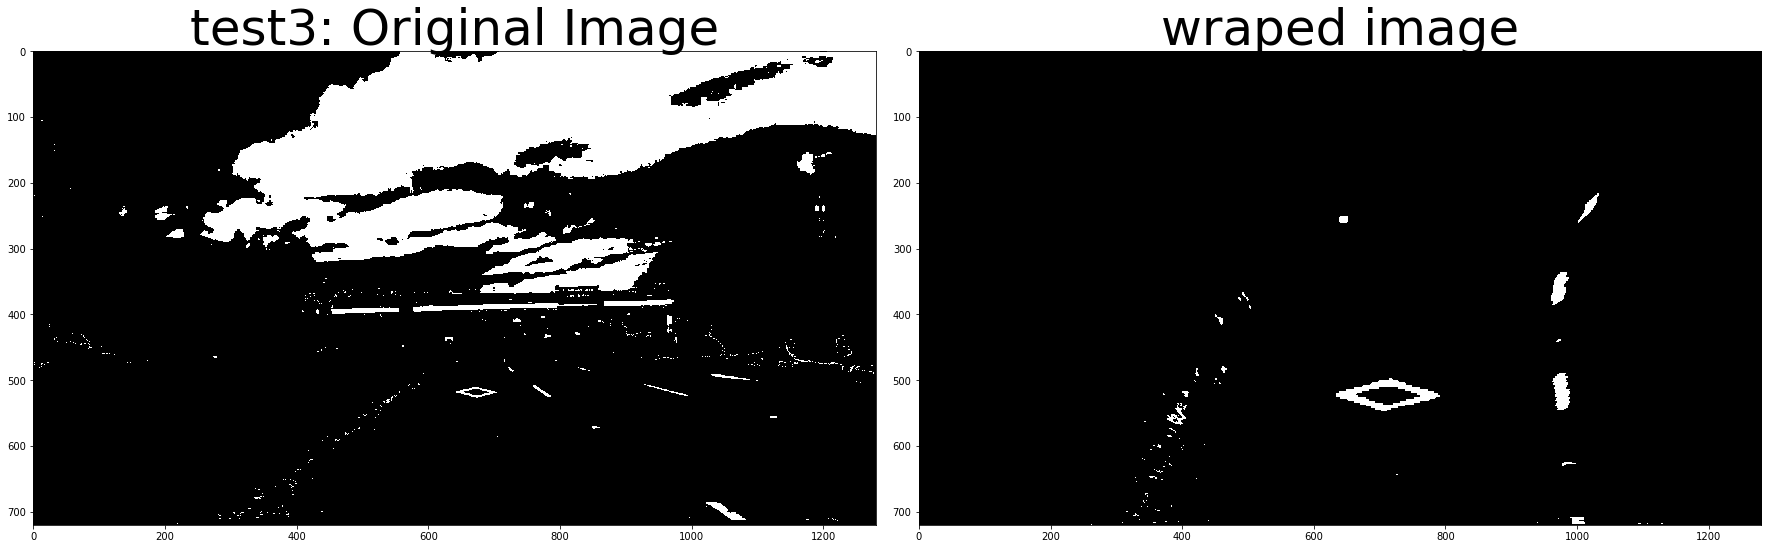

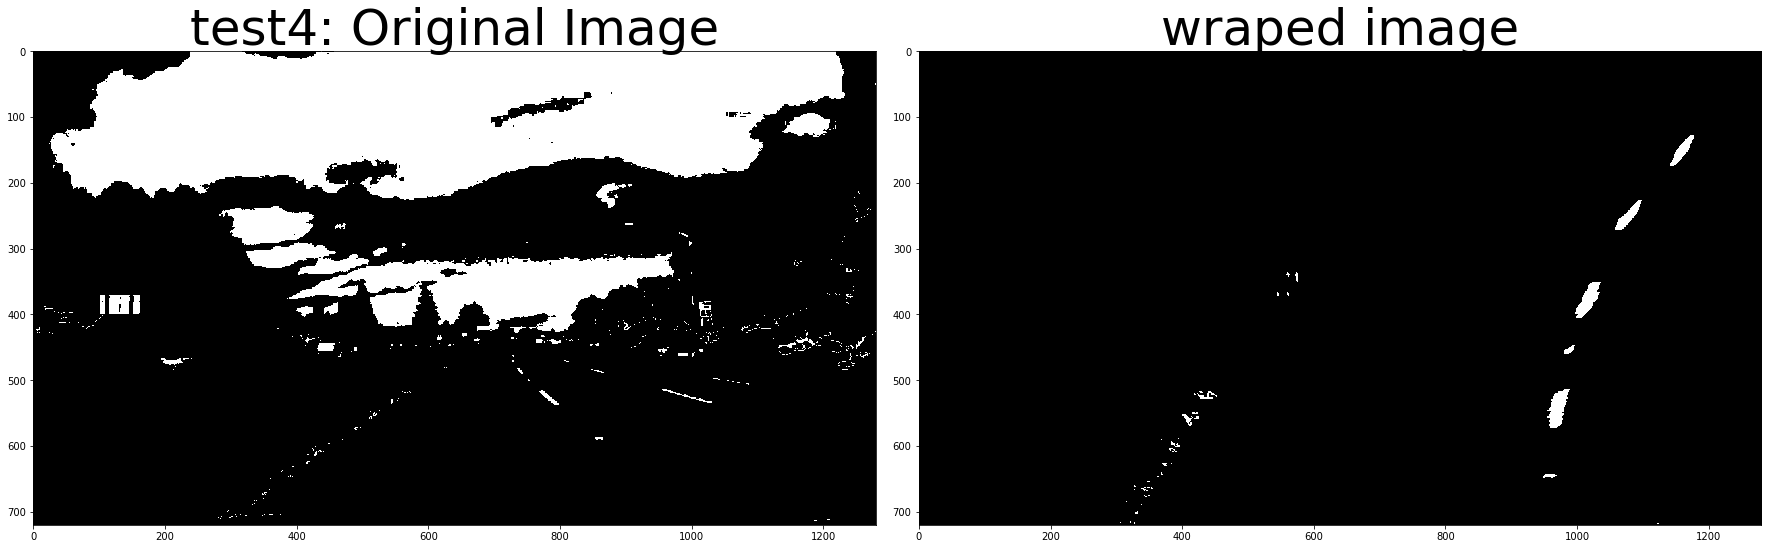

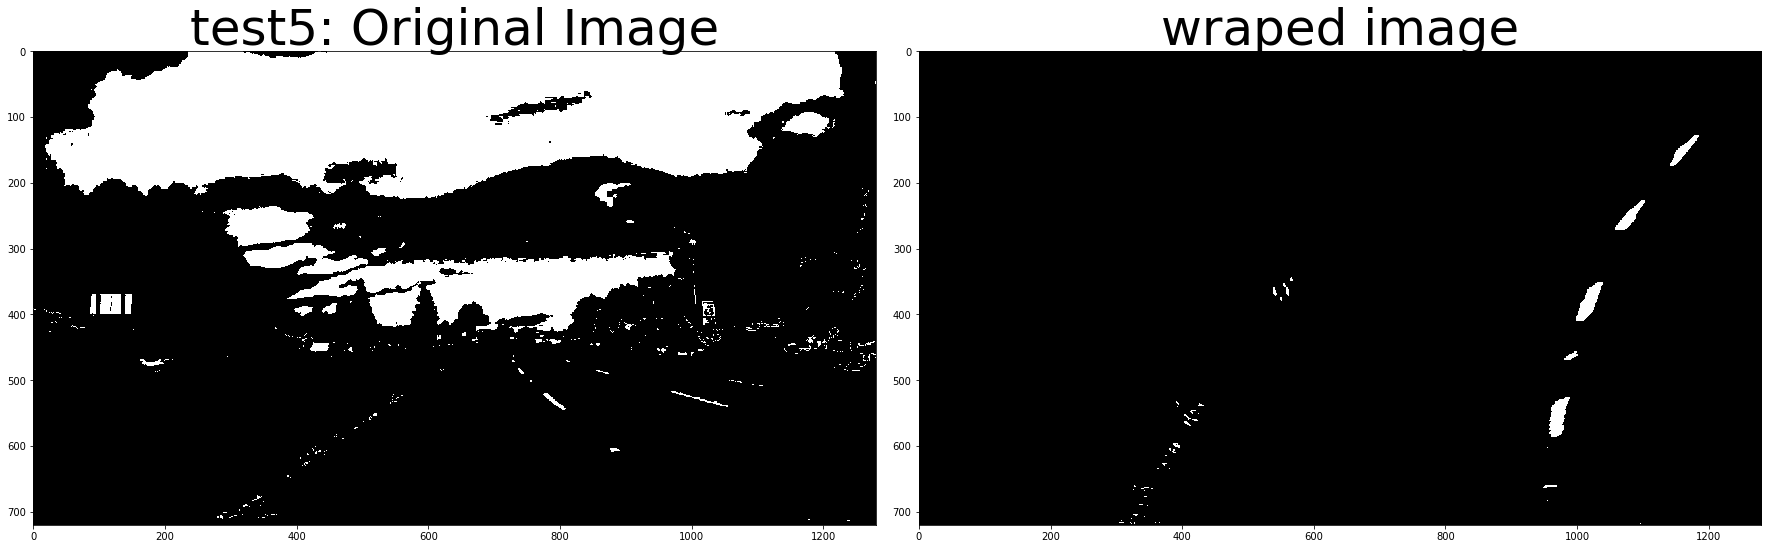

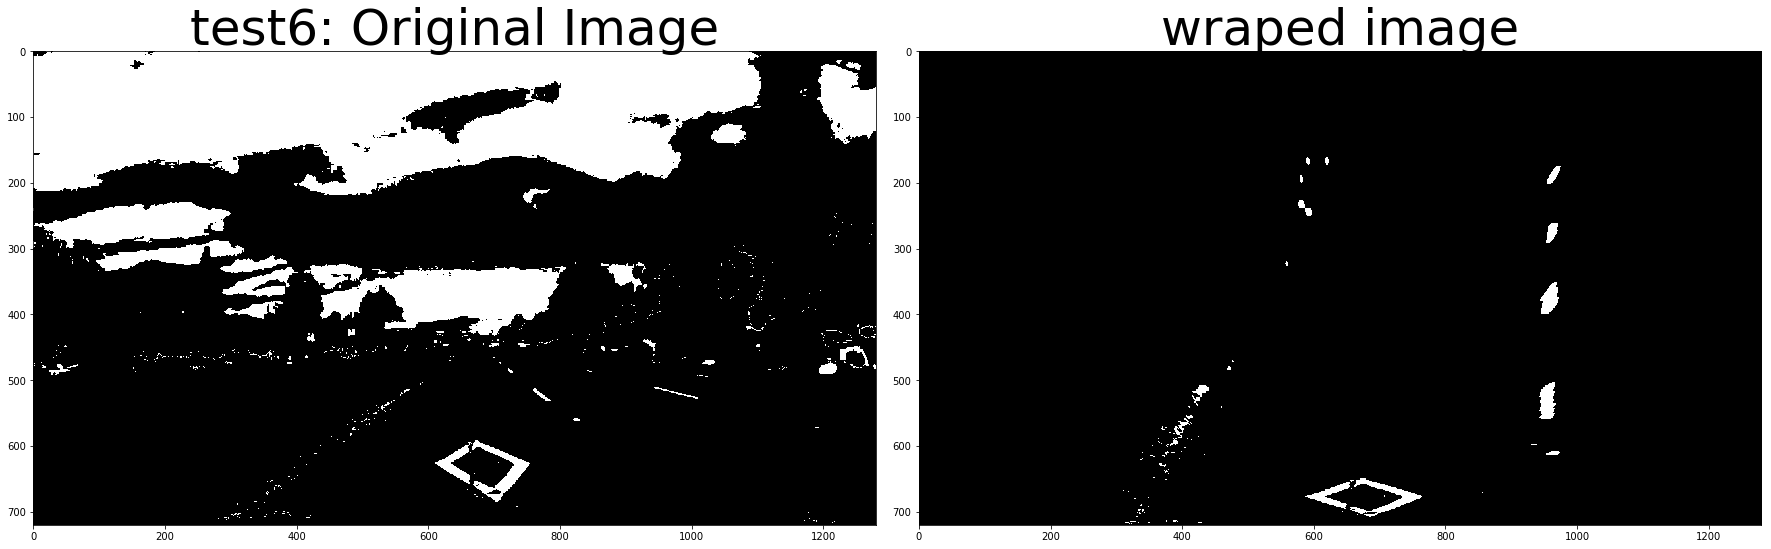

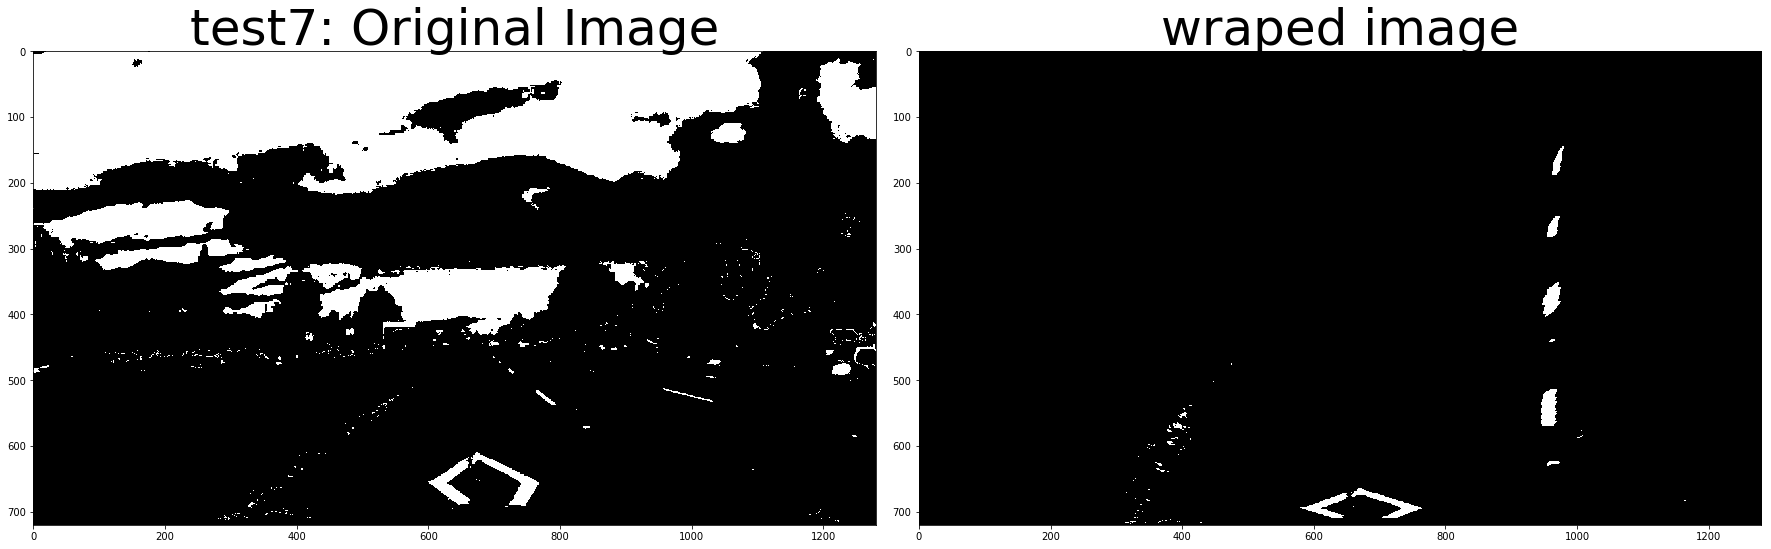

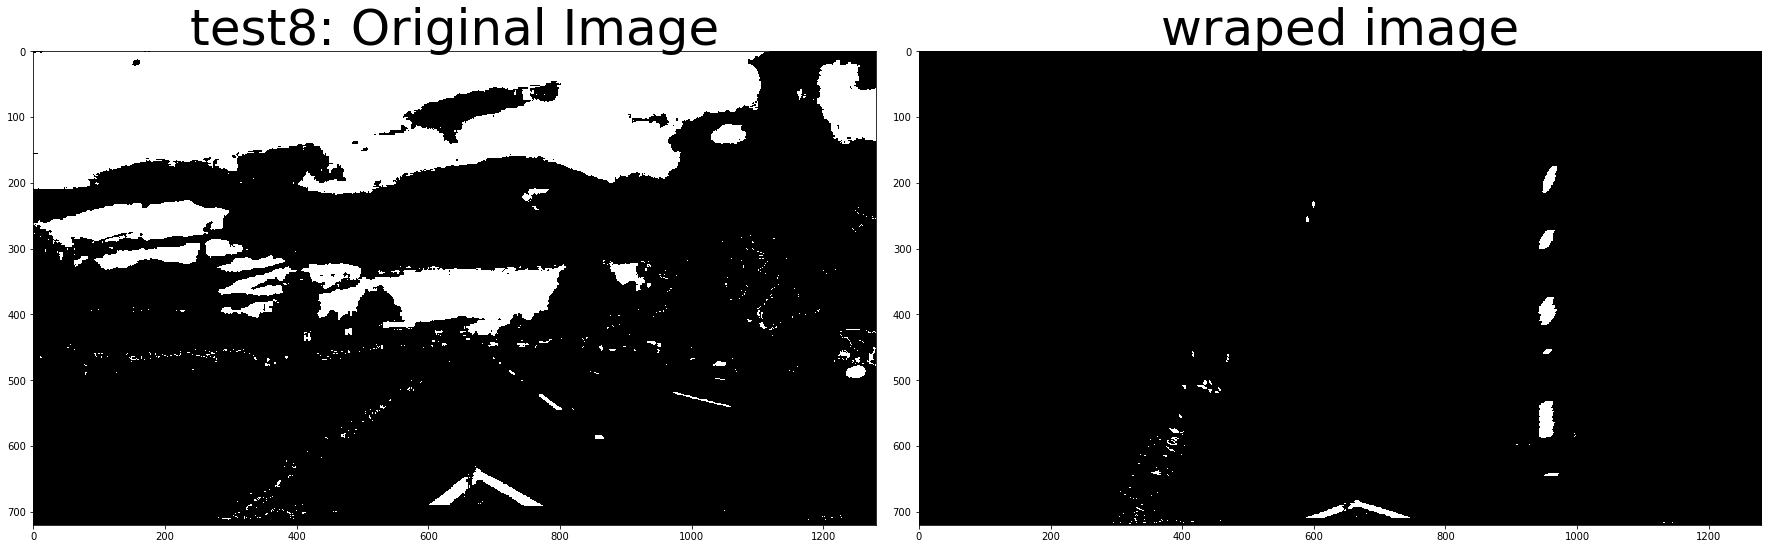

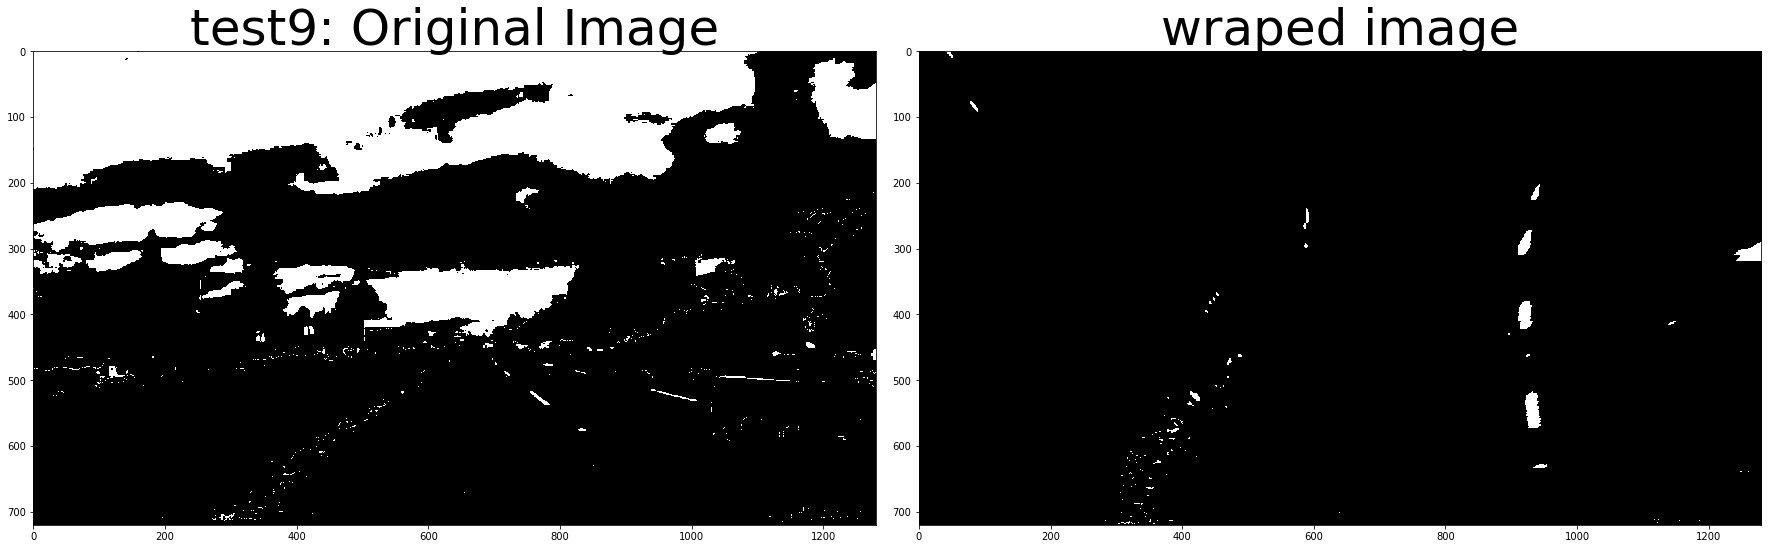

In [5]:
for file in images:
    # read the image
    figurename = file.split('\\')[-1]
    image = mping.imread(file)
    # undistort the image
    image = cal_undistort(image, img_points, obj_points)
    # use sobel function, combine grayscale and color channels
    binary_output = hls_pip(image, thres_s=S_thres, thres_h=H_thres,thres_l=L_thres)
    
    # convert the image into bird-eye view
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(binary_output, cmap='gray')
    ax1.set_title(figurename.split('.')[0]+': Original Image', fontsize=50)
    ax2.imshow(wrap(binary_output), cmap='gray')
    ax2.set_title('wraped image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    cv2.imwrite("./output_images/harder_challenge/output/" + figurename, wrap(binary_output)*255)

In [4]:
# find lane line by histogram and make a visulization

def histogram_find(file, nwindows=9, margin=100, minpix=50, plot=0, save=0, image=None, have=0):
    
    if have:
        binary_wraped = image
    else:
        binary_wraped = mping.imread(file)
    figurename = file.split('\\')[-1]
    
    # take a histogram of bottom half of the image
    histogram = np.sum(binary_wraped[binary_wraped.shape[0]//2:,:], axis=0)
    
    # generate a picture to visualize the result
    out_image = np.dstack((binary_wraped,binary_wraped,binary_wraped))
    
    # find the peak of the histogram as the starting point
    mid_point = (500,780)
    leftx_start = np.argmax(histogram[:mid_point[0]])
    rightx_start = np.argmax(histogram[mid_point[1]:]) + mid_point[1]
    
    #set the height of the sliding window
    window_height = np.int(histogram.shape[0]//nwindows)
    
    # find all the nonzero pixels
    nonzero = binary_wraped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # define the current position
    leftx_current = leftx_start
    rightx_current = rightx_start
    
    # list to save the left and right positions of pixels in the form of index
    left_lane_inds = []
    right_lane_inds = []
    
    # slide the window
    for window in range(nwindows):
        # define the window boundaries
        win_y_low = binary_wraped.shape[0] - (1 + window) * window_height
        win_y_high = binary_wraped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # visualize the window
        if plot:
            cv2.rectangle(out_image,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_image,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # find the nonzero pixel within the window in x and y
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # add the index into the list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # relocate the center of the window if find > minpix pixels
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Visualization
    if plot:
        ploty = np.linspace(0, binary_wraped.shape[0]-1, binary_wraped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]
        plt.figure()
        plt.imshow(out_image)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title(figurename, fontsize=50)
    
    # save the picture
    if save:
        plt.savefig('./output_images/histogram/'+figurename)
    return left_fit, right_fit

In [5]:
## if I know the fit lines in one frame, in the next frame of video 
## I only need to search the line in the area near the fit lines

def precious_search(file, left_fit, right_fit,margin=100, plot=0, save=0, image=None, have=0):
    figurename = file.split('\\')[-1]
    
    if have:
        binary_wraped = image
    else:
        binary_wraped = mping.imread(file)
    nonzero = binary_wraped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0] * nonzeroy ** 2 + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                     (nonzerox < (left_fit[0] * nonzeroy ** 2 + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * nonzeroy ** 2 + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                     (nonzerox < (right_fit[0] * nonzeroy ** 2 + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_wraped.shape[0]-1, binary_wraped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## visualization
    out_img = np.dstack((binary_wraped, binary_wraped, binary_wraped))
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Visualization
    if plot:
        plt.figure()
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title(figurename, fontsize=50)
        
    if save:
        plt.savefig('./output_images/histogram/precious_'+figurename)
    
    return left_fit, right_fit

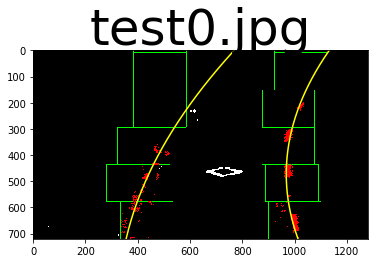

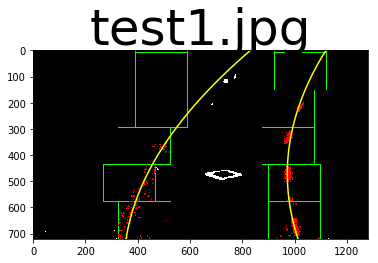

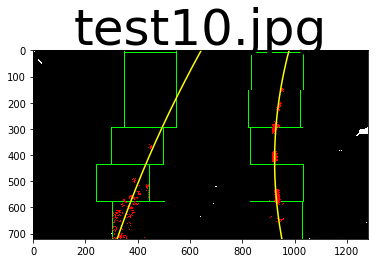

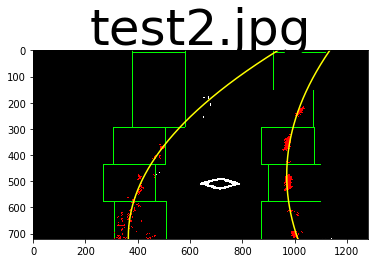

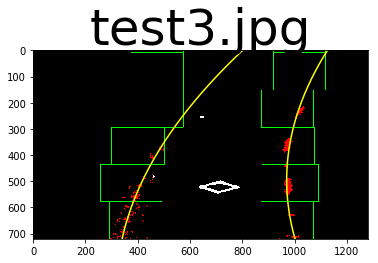

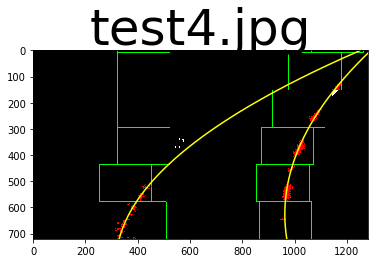

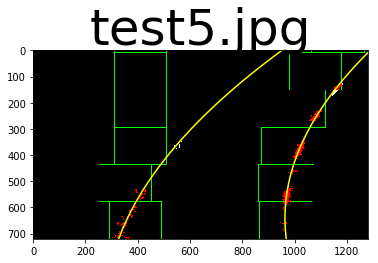

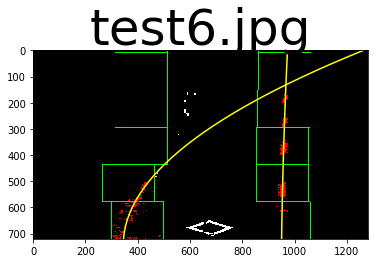

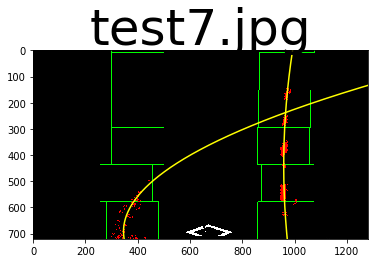

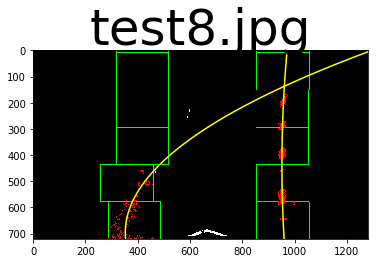

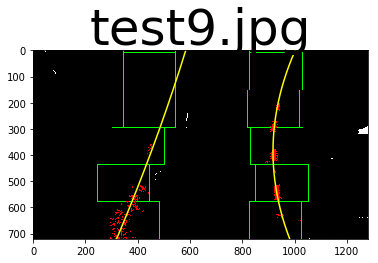

In [8]:
# test the function in each picture

files = glob.glob('./output_images/harder_challenge/output/test*.jpg')

for file in files:
    histogram_find(file,plot=1)# test the function in each picture

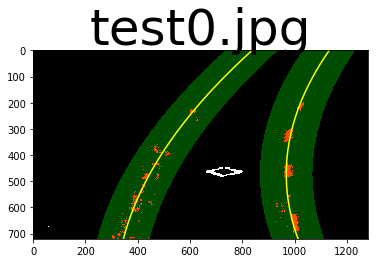

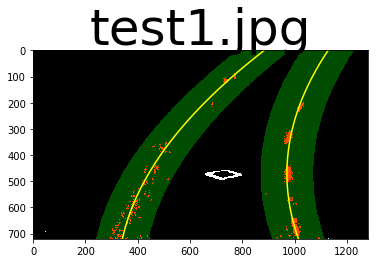

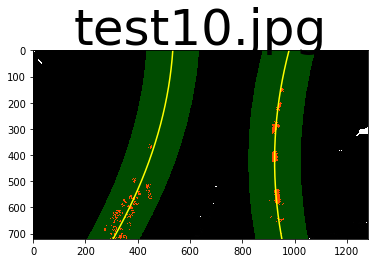

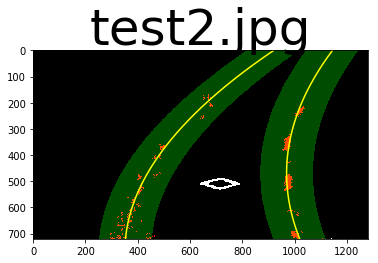

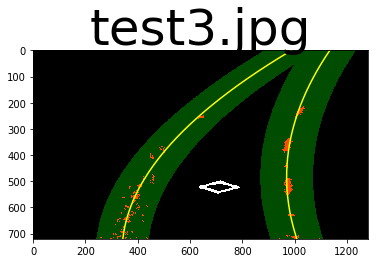

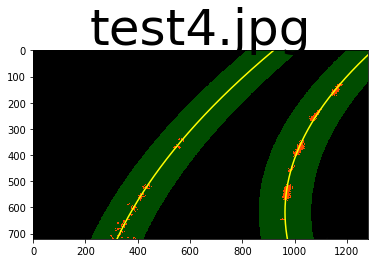

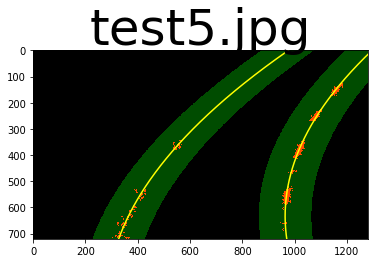

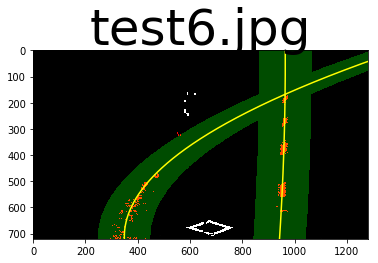

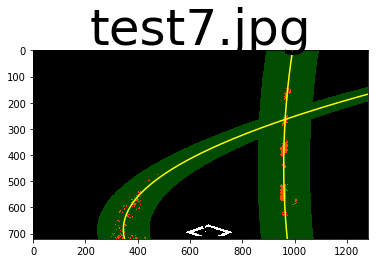

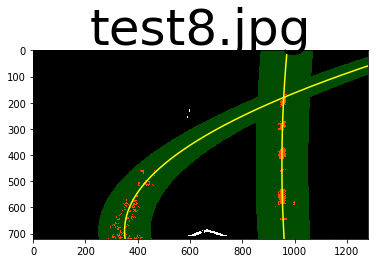

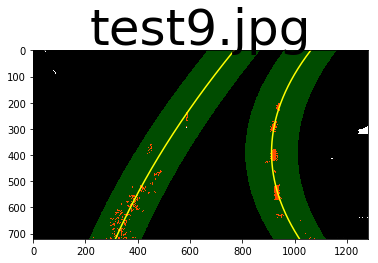

In [9]:
for file in files:
    left_fit, right_fit = histogram_find(file)
    precious_search(file, left_fit, right_fit, plot=1)

In [6]:
## define a function to calculate the curvature

def cal_curv(left_fit, right_fit):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # calculate the curvature around the car position(720 pixel)
    left_curv = ((1 + (2*left_fit[0]*720*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curv = ((1 + (2*right_fit[0]*720*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curv, right_curv

In [17]:
class Line():
    def __init__(self, n):
        # was the line detected in the last iteration?
        self.detected = False
        # set of the x values of fitted line over the last n iterations
        self.setx = []
        # average x values of the fitted line over the last n iterations
        self.iter_num = n
        self.bestx = None  
        # set of polynomial coefficients over the last n iterations
        self.set_poly = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # count the number of frame
        self.count = 0
        # strings for printing
        self.str1 = None
        self.str2 = None
        
    def update(self, fitline, curvature):
        self.count += 1
        ploty =  np.linspace(720,0, 720)
        self.radius_of_curvature = curvature
        
        if self.detected:
            
            if self.count <= self.iter_num:
                self.setx.append(self.best_fit[0] * ploty ** 2 + self.best_fit[1]*ploty + self.best_fit[2])
                self.set_poly.append(fitline)
            else:
                del self.setx[0]
                del self.set_poly[0]
                self.setx.append(self.best_fit[0] * ploty ** 2 + self.best_fit[1]*ploty + self.best_fit[2])
                self.set_poly.append(fitline)
            sumx = 0
            for i in range(len(self.setx)):
                sumx += self.setx[i]
            self.bestx = sumx/len(self.setx)
            sumpoly = 0
            for i in range(len(self.set_poly)):
                sumpoly += self.set_poly[i]
            self.best_fit = sumpoly/len(self.set_poly)
            
            self.line_base_pos = self.bestx[0] - 640
            
        else:
            self.detected = True
            self.set_poly.append(fitline)
            self.best_fit = fitline
            self.bestx = self.best_fit[0] * ploty ** 2 + self.best_fit[1]*ploty + self.best_fit[2]
            self.setx.append(self.best_fit[0] * ploty ** 2 + self.best_fit[1]*ploty + self.best_fit[2])
            self.line_base_pos = self.bestx[0] - 640

# define a function to check out wether the new result good or not
def check_output(left_fit, right_fit, oldleft = None, oldright = None, first = False):
    result = True
    ploty =  np.linspace(720,0,720)
    left_x = left_fit[0] * ploty ** 2 + left_fit[1]*ploty + left_fit[2]
    right_x = right_fit[0] * ploty ** 2 + right_fit[1]*ploty + right_fit[2]
    
    # checking that the left and right lane line are roughly parallel
    fit_diff = [np.abs(left_fit[0] - right_fit[0])/left_fit[0], np.abs(left_fit[1] - right_fit[1])/left_fit[1]]
    
    if fit_diff[0] > 0.5 or fit_diff[1] > 0.5:
        result = False
    if not first:
        # calculate the difference of polyfit parameters
        poly_diff_left = (oldleft.best_fit - left_fit) / oldleft.best_fit
        poly_diff_right = (oldright.best_fit - right_fit) / oldright.best_fit
        
        if not (abs(poly_diff_left)<np.array([0.7,0.5,0.2])).all() or \
            not (abs(poly_diff_right)<np.array([0.7,0.5,0.2])).all():
                result = False
                
    return result

In [14]:
## define the function for processing the videos

def pro_video(image):
    global Left
    global Right
    
    good = True
    src = np.float32([[190,720], [586,455], [696,455], [1130,720]])
    dst = np.float32([[240,720], [240,0], [1040,0], [1040, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # undistort the image
    undist = cal_undistort(image, img_points, obj_points)
    
    # pre-process the image and tranform into bird-eye view
    binary_output = hls_pip(undist, thres_s=S_thres, thres_h=H_thres,thres_l=L_thres)
    image = wrap(binary_output)*255
    
    # find the lane line
    if Left.detected:
        left_fit, right_fit = precious_search(file, Left.best_fit, Right.best_fit, image=image, have=1)
        if not check_output(left_fit, right_fit, Left, Right):
            left_fit, right_fit = histogram_find(file, image=image, have=1)
            if not check_output(left_fit, right_fit, Left, Right, first = True):
                good = False
    else:
        left_fit, right_fit = histogram_find(file, image=image, have=1)
    
    if good:
        # calculate the curvate 
        left_cur, right_cur = cal_curv(left_fit, right_fit)

        # update the information in the class
        Left.update(left_fit, left_cur)
        Right.update(right_fit, right_cur)
    
    # take the average information in the class
    left_fit = Left.best_fit
    right_fit = Right.best_fit
    
    y_array = np.linspace(720,0, 720)
    leftx = left_fit[0] * y_array ** 2 + left_fit[1]*y_array + left_fit[2]
    rightx = right_fit[0] * y_array ** 2 + right_fit[1]*y_array + right_fit[2]
    
    # Create an image to draw the lines on
    warp_color = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, y_array]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, y_array])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_color, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_color, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # print the curvatue on the image every 5 frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    if (Left.count-1) % 5 == 0:
        curc = round(0.5*(Left.radius_of_curvature + Right.radius_of_curvature)/1000, 2)
        Left.str1 = 'The curvate of the lane line: ' + str(curc) + ' km'

        # find the position of the car
        right_line_base = rightx[0]
        left_line_base = leftx[0]
        middle = 640
        distance = 0.5 * (Left.line_base_pos + Right.line_base_pos)
        distance = round(distance * 3.7/700 * 100, 2)
        if distance < 0:
            Left.str2 = 'right of the center: ' + str(abs(distance)) + ' cm'
        else:
            Left.str2 = 'left of the center: ' + str(abs(distance)) + ' cm'
            
    cv2.putText(result,Left.str1,(400,650), font, 1,(0,0,255),2,cv2.LINE_AA)
    cv2.putText(result,Left.str2,(400,700), font, 1,(0,0,255),2,cv2.LINE_AA)
    
    return result    
    

In [16]:
from moviepy.editor import VideoFileClip

Left = Line(5)
Right = Line(5)

myclip = VideoFileClip('./project_video.mp4')
clip = myclip.fl_image(pro_video)
%time clip.write_videofile('./output_videos/video.mp4', audio=False)


[MoviePy] >>>> Building video ./output_videos/video.mp4
[MoviePy] Writing video ./output_videos/video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:43<00:01,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/video.mp4 

Wall time: 21min 45s


In [17]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/video.mp4'))

In [13]:
from moviepy.editor import VideoFileClip

Left = Line(5)
Right = Line(5)

myclip = VideoFileClip('challenge_video.mp4')
clip = myclip.fl_image(pro_video)
%time clip.write_videofile('./output_videos/challenge_video.mp4', audio=False)

[MoviePy] >>>> Building video ./output_videos/challenge_video.mp4
[MoviePy] Writing video ./output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [08:10<00:00,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video.mp4 

Wall time: 8min 12s


In [14]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/challenge_video.mp4'))

In [19]:
# take the frames where bad results first appear

take_list = [0,6,7,8,23,93,94,103,104,105,123,139,140,154,174,196]

VideoCapture = cv2.VideoCapture()
VideoCapture.open("./harder_challenge_video.mp4")

j = 0
i = 0
ret = True
while ret:
    ret, frame = VideoCapture.read()
    if i in take_list:
        cv2.imwrite("./output_images/harder_challenge/test" + str(j) + '.jpg', frame)
        j = j + 1
    i = i + 1

In [18]:
# generate every frames of the result video to find the frame where bad results first appear.

VideoCapture = cv2.VideoCapture()
VideoCapture.open("./output_videos/harder_challenge_video.mp4")

i = 0
ret = True
while ret:
    ret, frame = VideoCapture.read()
    cv2.imwrite("./output_images/harder_challenge/origin/test" + str(i) + '.jpg', frame)
    i = i + 1

In [15]:
from moviepy.editor import VideoFileClip

Left = Line(5)
Right = Line(5)

myclip = VideoFileClip('harder_challenge_video.mp4')
clip = myclip.fl_image(pro_video)
%time clip.write_videofile('./output_videos/harder_challenge_video.mp4', audio=False)

[MoviePy] >>>> Building video ./output_videos/harder_challenge_video.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video.mp4



  6%|████▍                                                                           | 67/1200 [01:04<18:17,  1.03it/s]


 11%|████████▉                                                                      | 135/1200 [02:12<17:25,  1.02it/s]


 16%|████████████▉                                                                  | 197/1200 [03:10<16:09,  1.03it/s]

TypeError: expected non-empty vector for x

In [16]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/harder_challenge_video.mp4'))